## 1. Analisis exploratorio

### 1.1 Importar Librerias

In [45]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

### 1.2 Lectura de datos

In [18]:
df1 = pd.read_csv('../data/info_01.csv')
df2 = pd.read_csv('../data/info_02.csv')

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17286 entries, 0 to 17285
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      17286 non-null  int64  
 1   id2     17286 non-null  int64  
 2   v4      17286 non-null  float64
 3   v5      17286 non-null  float64
 4   v6      17286 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 675.4 KB


In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17286 entries, 0 to 17285
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      17286 non-null  int64  
 1   id2     17286 non-null  int64  
 2   v1      17286 non-null  float64
 3   c1      17286 non-null  int64  
 4   v2      17286 non-null  float64
 5   v3      16286 non-null  object 
dtypes: float64(2), int64(3), object(1)
memory usage: 810.4+ KB


In [21]:
df1.head()

id  id2     v4    v5        v6
0   1    1  721.2  27.3  0.004793
1   1    1  721.2  27.3  0.004793
2   2    2  714.0  27.3  0.004783
3   2    2  714.0  27.3  0.004783
4   3    3  713.5  27.2  0.004779

In [22]:
df2.head()

id  id2     v1  c1    v2                   v3
0   1    1  426.0   1  23.2  2015-02-04 17:51:00
1   1    1  426.0   1  23.2  2015-02-04 17:51:00
2   2    2  429.5   1  23.1  2015-02-04 17:51:59
3   2    2  429.5   1  23.1  2015-02-04 17:51:59
4   3    3  426.0   1  23.1  2015-02-04 17:53:00

### 1.3 Limpieza de datos 

In [23]:
#Quitar nulos solo en info2 aparecen nulos
df2 = df2.dropna()
len(df2)


16286

In [24]:
#Quitar duplicados, ya que se ve que los ids se repiten con la misma información. 
df1 = df1.drop_duplicates( 
  subset = ['id', 'id2'], 
  keep = 'last').reset_index(drop = True) 

df2 = df2.drop_duplicates( 
  subset = ['id', 'id2'], 
  keep = 'last').reset_index(drop = True) 

In [25]:
#Validar que tengan misma cantidad de filas
len(df1), len(df2)

(8143, 8143)

### 1.4 Merge dataframes

In [26]:
df = pd.merge(df2, df1, on="id", how='inner') 

#solo valido si alguna diferencia entre las id2 deberia regresar sin filas filter_id2
filter_id2 = df[df['id2_x'] != df['id2_y']]
filter_id2

Empty DataFrame
Columns: [id, id2_x, v1, c1, v2, v3, id2_y, v4, v5, v6]
Index: []

In [27]:
df.head()

id  id2_x     v1  c1    v2                   v3  id2_y     v4    v5  \
0   1      1  426.0   1  23.2  2015-02-04 17:51:00      1  721.2  27.3   
1   2      2  429.5   1  23.1  2015-02-04 17:51:59      2  714.0  27.3   
2   3      3  426.0   1  23.1  2015-02-04 17:53:00      3  713.5  27.2   
3   4      4  426.0   1  23.1  2015-02-04 17:54:00      4  708.2  27.2   
4   5      5  426.0   1  23.1  2015-02-04 17:55:00      5  704.5  27.2   

         v6  
0  0.004793  
1  0.004783  
2  0.004779  
3  0.004772  
4  0.004757

### 1.5 Cambio de datos y arreglos

In [28]:
df.drop('id2_y', axis=1, inplace=True)
df = df.rename({"id2_x": "id2"}, axis=1)

#cambiar v3 por fecha a datetime y drop v3
df["fecha"] = pd.to_datetime(df['v3'], format="%Y-%m-%d %H:%M:%S")

df.drop(columns=['v3'], inplace=True)

In [29]:
#Quitar IDs despues del merge
df.drop(columns=['id', 'id2'], inplace=True)

In [30]:
df = df.reindex(columns=['fecha','v1','v2','v4','v5','v6', 'c1'])
df.head()

fecha     v1    v2     v4    v5        v6  c1
0 2015-02-04 17:51:00  426.0  23.2  721.2  27.3  0.004793   1
1 2015-02-04 17:51:59  429.5  23.1  714.0  27.3  0.004783   1
2 2015-02-04 17:53:00  426.0  23.1  713.5  27.2  0.004779   1
3 2015-02-04 17:54:00  426.0  23.1  708.2  27.2  0.004772   1
4 2015-02-04 17:55:00  426.0  23.1  704.5  27.2  0.004757   1

### 1.6 Normalizacion

In [31]:
def normalize_dataframe(df_in):
    df_out = df_in.copy()  # Crea una copia del DataFrame original
    for col in df_out.columns:
        if col not in ["fecha"]:
            min_val = df_out[col].min()
            max_val = df_out[col].max()
            df_out[col] = (df_out[col] - min_val) / (max_val - min_val)

    return df_out

df_norm = normalize_dataframe(df_in=df)

### 1.7 Distribuciones de los datos

In [32]:
#Validar que c1 solo se comporta como binaria
df['c1'].value_counts()

0    6414
1    1729
Name: c1, dtype: int64

In [33]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_norm['v4'], name='v4'))
fig.add_trace(go.Histogram(x=df_norm['v5'], name='v5'))
fig.add_trace(go.Histogram(x=df_norm['v6'], name='v6'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_layout(title='Grafica de distribuciones')
fig.update_layout(title_x=0.5, title_y=0.9)
fig.show()

In [34]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_norm['v1'], name='v1'))
fig.add_trace(go.Histogram(x=df_norm['v2'], name='v2'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_layout(title='Grafica de distribuciones')
fig.update_layout(title_x=0.5, title_y=0.9)
fig.show()

### 1.8 Matriz de Correlacion

In [36]:
correlation_matrix = df.corr()
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='Viridis',
                text_auto=True)

fig.update_xaxes(side="top")

fig.show()

### 1.5 Datos vs Tiempo

In [37]:
fig = px.line(df_norm, x='fecha', y=['c1', 'v1', 'v2', 'v4', 'v5', 'v6'], title='Gráfico de Datos vs. Tiempo')

# Personaliza el diseño del gráfico
fig.update_layout(
    xaxis_title='Tiempo',
    yaxis_title='Valor',
    legend_title='Columnas de Datos',
)

# Muestra el gráfico
fig.show()

### 1.6 Resultados
Datos observados:
- Parece ser que C1 cuando se activa crece v4 y si se apaga reduce v4
- Parece que v5 y v6 estan demasiado correlacionadas entre ellas pero no parecen que tengan un patron con C1
- Con v1 parece que con un umbral y tiempo dentro de ese umbral se activa C1

## 2 Creación de Modelo ( k-Means - Cluster No Supervisado)

In [66]:
# Seleccionar variables
X = df_norm[["c1","v1", "v2", "v4", "v5", "v6"]]

# Definir la función de la regla del codo
def elbow(X, n_clusters):
    inertia = []
    for i in range(1, n_clusters + 1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    return inertia

# Definir la función de la regla del codo
def elbow(X, n_clusters):
    inertia = []
    for i in range(1, n_clusters + 1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    return inertia

# Obtener la inercia para diferentes valores de n_clusters
inertia = elbow(X, 10)

# Visualizar la inercia
fig = px.line(x=range(1, len(inertia) + 1), y=inertia)
fig.update_layout(xaxis_title="Número de clusters", yaxis_title="Inercia")
fig.show()

In [67]:
# Seleccionar el número de clusters óptimo en teoria la grafica dice que es 3 pero escogeremos 2 para este problema
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
# Obtener las etiquetas de los clusters
labels = kmeans.labels_
# Agrega las etiquetas de los clusters al DataFrame copy
dfkmeans = df.copy()
dfkmeans["cluster"] = labels

In [48]:
dfkmeans.head()

fecha     v1    v2     v4    v5        v6  c1  cluster
0 2015-02-04 17:51:00  426.0  23.2  721.2  27.3  0.004793   1        1
1 2015-02-04 17:51:59  429.5  23.1  714.0  27.3  0.004783   1        1
2 2015-02-04 17:53:00  426.0  23.1  713.5  27.2  0.004779   1        1
3 2015-02-04 17:54:00  426.0  23.1  708.2  27.2  0.004772   1        1
4 2015-02-04 17:55:00  426.0  23.1  704.5  27.2  0.004757   1        1

In [68]:
#Para fines practicos observare las variables que mas vi con correlación.
fig = px.scatter(dfkmeans, x="v1", y="v4", color="cluster")
fig.update_layout(
    xaxis_title="Variable 1",
    yaxis_title="Variable 4",
    title="Gráfico de Dispersión 2D con Clustering"
)
fig.show()

In [69]:
from plotly.subplots import make_subplots

# Crear una figura con subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cluster", "C1"))

# Agregar el primer gráfico a la primera columna
fig.add_trace(px.scatter(dfkmeans, x="v1", y="v4", color="cluster").data[0], row=1, col=1)

# Agregar el segundo gráfico a la segunda columna
fig.add_trace(px.scatter(dfkmeans, x="v1", y="v4", color="c1").data[0], row=1, col=2)

# Actualizar títulos y etiquetas
fig.update_xaxes(title_text="Variable 1", row=1, col=1)
fig.update_xaxes(title_text="Variable 1", row=1, col=2)
fig.update_yaxes(title_text="Variable 4", row=1, col=1)
fig.update_yaxes(title_text="Variable 4", row=1, col=2)
fig.update_layout(title_text="Comparación de Gráficos 2D")

# Mostrar la figura con los subplots
fig.show()

In [ ]:
#Solo sirve para 3D
fig = px.scatter_3d(df_norm, x="v1", y="v2" ,z="v4", color="Cluster")
fig.update_layout(
    xaxis_title="Característica 1",
    yaxis_title="Variable 4",
    title="Gráfico de Dispersión 2D con Clustering"
)
fig.show()

### Metricas K-Means

In [102]:
# Calcular el accuracy
accuracy = (dfkmeans['c1'] == (1 - dfkmeans['cluster'])).mean()

# Calcular el error
error = 1 - accuracy

print(f'Accuracy: {accuracy:.2f}')
print(f'Error: {error:.2f}')

Accuracy: 1.00
Error: 0.00


## 3. Creación de cluster (DBA)

In [ ]:
# Especifica la columna de interés
columna_de_interes = 'v1'

# Calcular el rango intercuartílico (IQR)
Q1 = df[columna_de_interes].quantile(0.25)
Q3 = df[columna_de_interes].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar el DataFrame para eliminar outliers
df_sin_outliers = df[(df[columna_de_interes] >= limite_inferior) & (df[columna_de_interes] <= limite_superior)]

In [64]:
# Crear un objeto DBSCAN
dbscan = DBSCAN(eps=0.5 , min_samples=5)  # Puedes ajustar eps y min_samples según tus datos

# Seleccionar variables
X = df_norm[["c1", "v1", "v4"]]

# Ajustar el modelo DBSCAN a tus datos
dbscan.fit(X)

df_dba = df.copy()
# Agregar las etiquetas de cluster al DataFrame original
df_dba['cluster'] = dbscan.labels_

In [65]:
# Crear una figura con subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cluster", "C1"))

# Agregar el primer gráfico a la primera columna
fig.add_trace(px.scatter(df_dba, x="v1", y="v4", color="cluster").data[0], row=1, col=1)

# Agregar el segundo gráfico a la segunda columna
fig.add_trace(px.scatter(df_dba, x="v1", y="v4", color="c1").data[0], row=1, col=2)

# Actualizar títulos y etiquetas
fig.update_xaxes(title_text="Variable 1", row=1, col=1)
fig.update_xaxes(title_text="Variable 1", row=1, col=2)
fig.update_yaxes(title_text="Variable 4", row=1, col=1)
fig.update_yaxes(title_text="Variable 4", row=1, col=2)
fig.update_layout(title_text="Comparación de Gráficos 2D")

# Mostrar la figura con los subplots
fig.show()

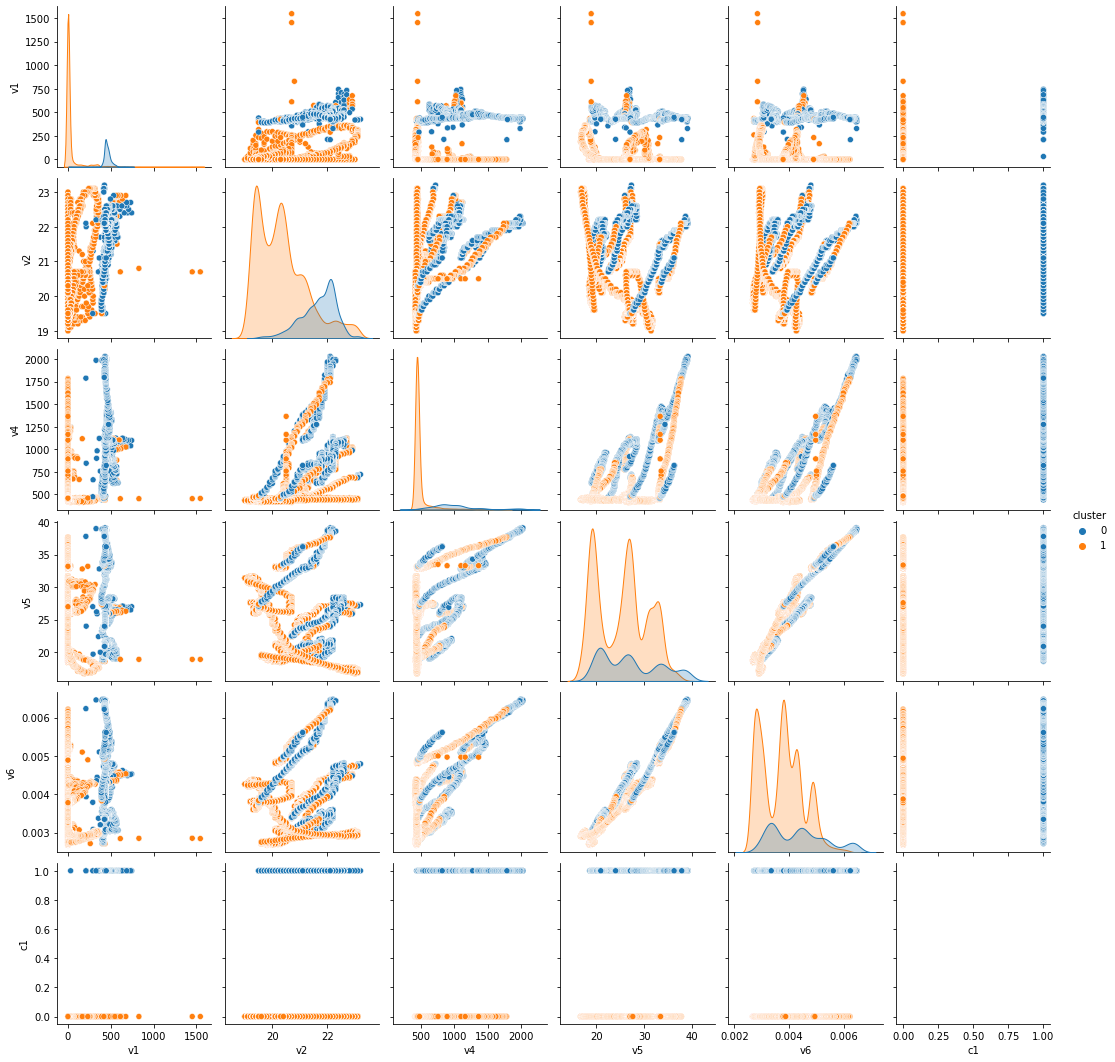

In [72]:
sns.pairplot(df_dba, hue="cluster")
plt.show()

### Metricas DBA

In [103]:
# Calcular el accuracy
accuracy = (df_dba['c1'] == (1 - df_dba['cluster'])).mean()

# Calcular el error
error = 1 - accuracy

print(f'Accuracy: {accuracy:.2f}')
print(f'Error: {error:.2f}')

Accuracy: 1.00
Error: 0.00


## 2 Modelo de Clasificación

In [77]:
dfClass = df_norm.copy()
dfClass.drop(columns=['fecha'], inplace=True)

In [79]:
# Separar las características (X) y la variable objetivo (y)
X = dfClass.drop("c1", axis=1)
y = dfClass["c1"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = XGBClassifier()

# Entrenar el modelo en los datos de entrenamiento
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calcular la métrica F1
f1 = f1_score(y_test, y_pred)

# Calcular la matriz de confusión y generar un informe de clasificación
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [81]:
# Imprimir métricas de evaluación
print("Métrica F1: {:.2f}".format(f1))
print("Informe de Clasificación:\n", report)

Métrica F1: 0.99
Informe de Clasificación:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1607
         1.0       0.98      1.00      0.99       429

    accuracy                           1.00      2036
   macro avg       0.99      1.00      0.99      2036
weighted avg       1.00      1.00      1.00      2036



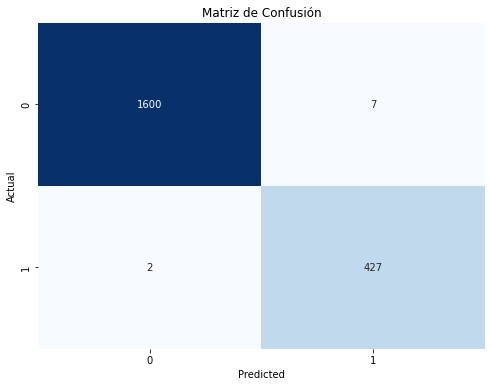

In [80]:
# Crear una figura
plt.figure(figsize=(8, 6))

# Crear el mapa de calor (heatmap) de la matriz de confusión con Seaborn
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)

# Personalizar etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

# Mostrar el gráfico
plt.show()

In [83]:
#Feature Importance
feature_importances = model.feature_importances_
feature_importances

array([0.8973265 , 0.03416698, 0.0303103 , 0.02206058, 0.01613555],
      dtype=float32)

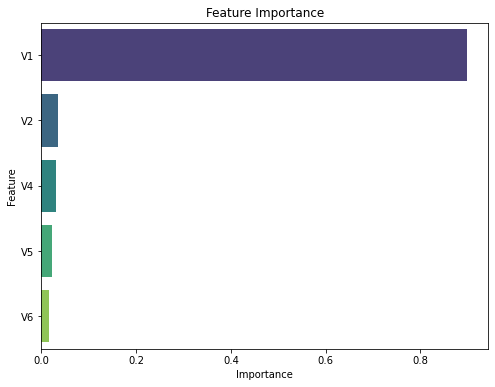

In [85]:
feature_names = ["V1", "V2", "V4", "V5", "V6"]  # Reemplaza con los nombres de tus características
df_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Crear una figura
plt.figure(figsize=(8, 6))

# Crear un gráfico de barras horizontal con Seaborn
sns.barplot(data=df_feature_importance, x='Importance', y='Feature', orient='h', palette='viridis')

# Personalizar títulos
plt.xlabel('Importance')
plt.title('Feature Importance')

# Mostrar el gráfico
plt.show()